In [1]:
import pandas as pd
import numpy as np

# 读取数据
data = pd.read_csv('adjusted_sleep_health_data.csv')

# 去重操作
data = data.drop_duplicates()

# 检查缺失值
missing_values = data.isnull().sum()
print("缺失值统计:")
print(missing_values)

# 若出现缺失值，使用均值填充数值变量的缺失值
numeric_cols = ['Sleep Duration (hours)', 'Quality of Sleep (scale: 1-10)', 
               'Physical Activity Level (minutes/day)', 'Stress Level (scale: 1-10)',
               'Heart Rate (bpm)', 'Daily Steps','Systolic BP', 'Diastolic BP']
for col in numeric_cols:
    if data[col].isnull().sum() > 0:
        data[col].fillna(round(data[col].mean()), inplace=True)

# 异常值处理
# 根据年龄判断心率是否正常
def is_normal_heart_rate(age, heart_rate):
    if age < 18:
        return 60 <= heart_rate <= 100
    elif 18 <= age <= 60:
        return 60 <= heart_rate <= 100
    else:  # 年龄 > 60
        return 50 <= heart_rate <= 90
    
# 判断血压是否正常
def is_normal_blood_pressure(systolic_bp, diastolic_bp):
    return 90 <= systolic_bp <= 140 and 60 <= diastolic_bp <= 90

# 检查并处理异常值
def check_and_mark_abnormal(data):
    
    # 计算每列的均值
    heart_rate_mean = int(data['Heart Rate (bpm)'].mean())
    systolic_bp_mean = data['Systolic BP'].mean()
    diastolic_bp_mean = data['Diastolic BP'].mean()
    
    # 检查心率并标记异常值为均值
    data.loc[~data.apply(lambda row: is_normal_heart_rate(row['Age'], row['Heart Rate (bpm)']), axis=1), 'Heart Rate (bpm)'] = heart_rate_mean

   # 检查血压并替换异常值为均值
    data.loc[~data.apply(lambda row: is_normal_blood_pressure(row['Systolic BP'], row['Diastolic BP']), axis=1), 'Systolic BP'] = systolic_bp_mean
    data.loc[~data.apply(lambda row: is_normal_blood_pressure(row['Systolic BP'], row['Diastolic BP']), axis=1), 'Diastolic BP'] = diastolic_bp_mean

    return data

# 处理异常值
data = check_and_mark_abnormal(data)

# 输出处理后的数据
print(data.head())

# 保存处理后的数据到新的 CSV 文件
data.to_csv('cleaned_sleep_health_data.csv', index=False)
print("数据已处理完毕")

缺失值统计:
Person ID                                0
Gender                                   0
Age                                      0
Occupation                               0
Sleep Duration (hours)                   0
Quality of Sleep (scale: 1-10)           0
Physical Activity Level (minutes/day)    0
Stress Level (scale: 1-10)               0
BMI Category                             0
Heart Rate (bpm)                         0
Daily Steps                              0
Sleep Disorder                           0
Systolic BP                              0
Diastolic BP                             0
dtype: int64
   Person ID  Gender   Age         Occupation  Sleep Duration (hours)  \
0          1    Male  25.0  Healthcare Worker                       6   
1          2  Female  35.0       Manual Labor                       6   
2          3  Female  34.0       Manual Labor                       6   
3          4  Female  18.0            Student                       6   
4          5 

In [32]:
import pandas as pd
data = pd.read_csv('cleaned_sleep_health_data.csv')
# 计算基本统计量
descriptive_stats = data.describe()
print("基本统计量：")
print(descriptive_stats)

# 计算相关系数
correlation_matrix = data.corr()

# 特定变量之间的相关性
print("\n精神压力水平与睡眠质量的相关性：", correlation_matrix.loc['Stress Level (scale: 1-10)', 'Quality of Sleep (scale: 1-10)'])
print("睡眠时长与睡眠质量的相关性：", correlation_matrix.loc['Sleep Duration (hours)', 'Quality of Sleep (scale: 1-10)'])
print("年龄与睡眠质量的相关性：", correlation_matrix.loc['Age', 'Quality of Sleep (scale: 1-10)'])
print("每日步数与睡眠质量的相关性：", correlation_matrix.loc['Daily Steps', 'Quality of Sleep (scale: 1-10)'])
print("心率与睡眠质量的相关性：", correlation_matrix.loc['Heart Rate (bpm)', 'Quality of Sleep (scale: 1-10)'])
print("每日运动时长与睡眠质量的相关性：", correlation_matrix.loc['Physical Activity Level (minutes/day)', 'Quality of Sleep (scale: 1-10)'])
print("血压收缩压与睡眠质量的相关性：", correlation_matrix.loc['Systolic BP', 'Quality of Sleep (scale: 1-10)'])
print("血压舒张压与睡眠质量的相关性：", correlation_matrix.loc['Diastolic BP', 'Quality of Sleep (scale: 1-10)'])


基本统计量：
         Person ID          Age  Sleep Duration (hours)  \
count  10000.00000  10000.00000            10000.000000   
mean    5000.50000     40.37430                6.205500   
std     2886.89568     14.03999                0.749484   
min        1.00000     18.00000                4.000000   
25%     2500.75000     30.00000                6.000000   
50%     5000.50000     40.00000                6.000000   
75%     7500.25000     50.00000                6.000000   
max    10000.00000     90.00000               10.000000   

       Quality of Sleep (scale: 1-10)  Physical Activity Level (minutes/day)  \
count                    10000.000000                            10000.00000   
mean                         6.184800                               40.23050   
std                          1.618985                               20.63526   
min                          1.000000                               10.00000   
25%                          5.000000                        

The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from econml.dml import DML
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report
from sklearn.tree import DecisionTreeClassifier

# 加载数据
data = pd.read_csv('cleaned_sleep_health_data.csv')

# 数据预处理
# 将分类变量转换为数值变量
label_encoders = {}
for column in data.columns:
    if data[column].dtype == 'object':
        le = LabelEncoder()
        data[column] = le.fit_transform(data[column])
        label_encoders[column] = le

# 填充缺失值
imputer = SimpleImputer(strategy='mean')
data_imputed = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)

# 定义因变量和自变量
X = data_imputed.drop(columns=['Quality of Sleep (scale: 1-10)', 'Sleep Disorder'])
y = data_imputed['Quality of Sleep (scale: 1-10)']
treatment = data_imputed['Sleep Disorder']  # 假设以 Sleep Disorder 作为处理变量

# 划分训练集和测试集
X_train, X_test, y_train, y_test, treatment_train, treatment_test = train_test_split(
    X, y, treatment, test_size=0.2, random_state=42
)

# 标准化数据
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print(X.columns)

Index(['Person ID', 'Gender', 'Age', 'Occupation', 'Sleep Duration (hours)',
       'Physical Activity Level (minutes/day)', 'Stress Level (scale: 1-10)',
       'BMI Category', 'Heart Rate (bpm)', 'Daily Steps', 'Systolic BP',
       'Diastolic BP'],
      dtype='object')


In [3]:
from econml.dml import DML
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

# 定义机器学习模型
model_y = RandomForestRegressor(n_estimators=100, random_state=42)
model_t = RandomForestClassifier(n_estimators=100, random_state=42)
model_final = RandomForestRegressor(n_estimators=100, random_state=42)

# 构建DML模型
dml = DML(
    
    model_y=model_y,
    model_t=model_t,
    model_final=model_final,
    discrete_treatment=True,
    random_state=42
)

# 拟合DML模型
dml.fit(y_train, treatment_train, X=X_train_scaled)

# 估计因果效应
causal_effect = dml.effect(X_test_scaled)
print("因果效应估计：", causal_effect)

The final model has a nonzero intercept for at least one outcome; it will be subtracted, but consider fitting a model without an intercept if possible.


因果效应估计： [ 1.01834068 -1.07235932 -0.84485932 ... -0.48835932 -1.95025932
 -0.55455932]


In [4]:
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression  # 修改了导入路径

# 使用 statsmodels 进行回归分析
X_train_sm = sm.add_constant(X_train_scaled)  # 添加常数项
model_sm = sm.OLS(y_train, X_train_sm).fit()
print(model_sm.summary())

# 使用 scikit-learn 进行回归分析
reg_model = LinearRegression()
reg_model.fit(X_train_scaled, y_train)

# 回归系数
print("回归系数：", reg_model.coef_)

# F检验
f_statistic, p_value = f_regression(X_train_scaled, y_train)
print("F统计量：", f_statistic)
print("P值：", p_value)

                                  OLS Regression Results                                  
Dep. Variable:     Quality of Sleep (scale: 1-10)   R-squared:                       0.458
Model:                                        OLS   Adj. R-squared:                  0.457
Method:                             Least Squares   F-statistic:                     561.8
Date:                            Wed, 11 Jun 2025   Prob (F-statistic):               0.00
Time:                                    10:36:34   Log-Likelihood:                -12751.
No. Observations:                            8000   AIC:                         2.553e+04
Df Residuals:                                7987   BIC:                         2.562e+04
Df Model:                                      12                                         
Covariance Type:                        nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------

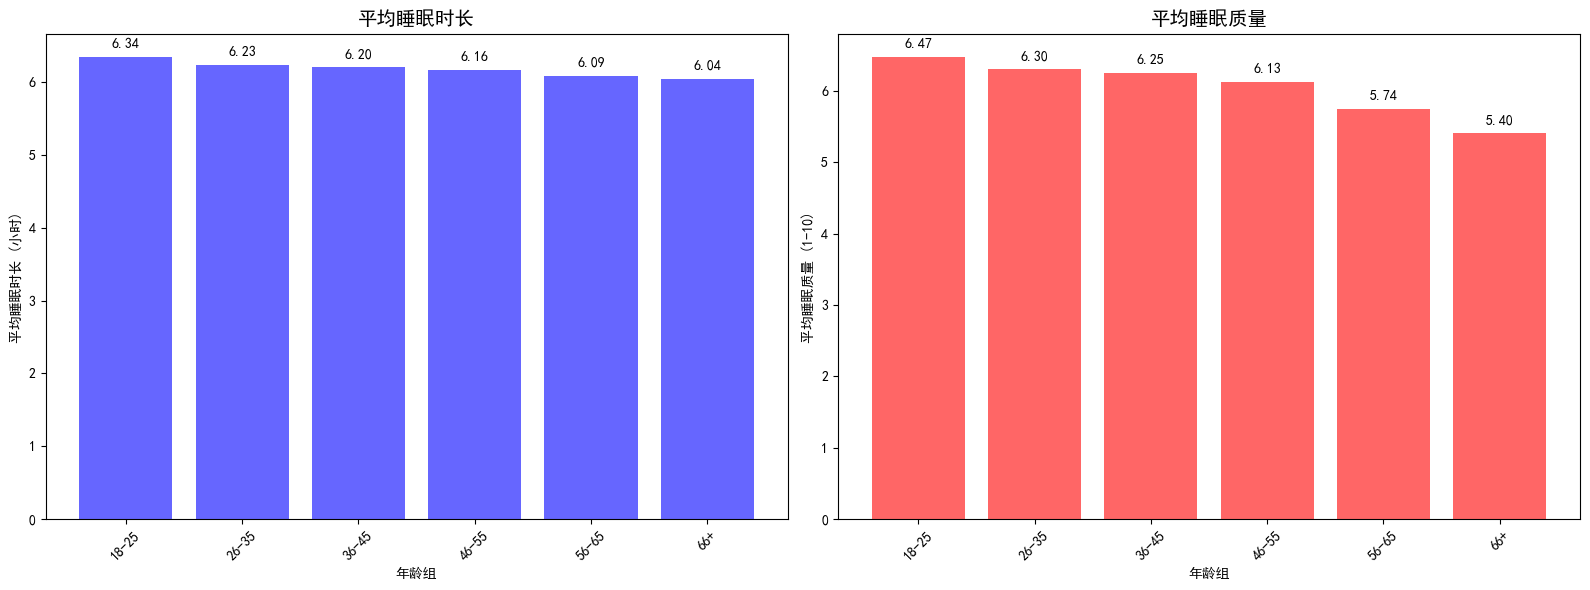

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib.ticker import FixedLocator, FixedFormatter
plt.rcParams['font.family'] = 'Simhei'      # 中文正常显示
plt.rcParams['axes.unicode_minus'] = False  # 负号正常显示

# 加载数据
data = pd.read_csv('cleaned_sleep_health_data.csv')

# 定义年龄组
age_groups = {
    '18-25': (18, 25),
    '26-35': (26, 35),
    '36-45': (36, 45),
    '46-55': (46, 55),
    '56-65': (56, 65),
    '66+': (66, 100)  # 假设最大年龄为100
}

# 创建一个新的列 'Age Group'
data['Age Group'] = pd.cut(data['Age'], bins=[age_groups[k][0] for k in age_groups.keys()] + [101], 
                          labels=age_groups.keys(), right=False)

# 按年龄组分组，计算平均睡眠时长和睡眠质量评分
grouped_data = data.groupby('Age Group').agg({
    'Sleep Duration (hours)': 'mean',
    'Quality of Sleep (scale: 1-10)': 'mean'
}).reset_index()

# 绘制柱状图
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True)

# 绘制平均睡眠时长
bars1 = axes[0].bar(grouped_data['Age Group'], grouped_data['Sleep Duration (hours)'], 
                   color='b', alpha=0.6)
axes[0].set_title('平均睡眠时长', fontsize=14)
axes[0].set_xlabel('年龄组')
axes[0].set_ylabel('平均睡眠时长 (小时)')
axes[0].tick_params(axis='x', rotation=45)

# 在柱状图上方标注数值
for bar in bars1:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{height:.2f}', ha='center', va='bottom')

# 绘制平均睡眠质量评分
bars2 = axes[1].bar(grouped_data['Age Group'], grouped_data['Quality of Sleep (scale: 1-10)'], 
                   color='r', alpha=0.6)
axes[1].set_title('平均睡眠质量', fontsize=14)
axes[1].set_xlabel('年龄组')
axes[1].set_ylabel('平均睡眠质量 (1-10)')
axes[1].tick_params(axis='x', rotation=45)

# 在柱状图上方标注数值
for bar in bars2:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{height:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

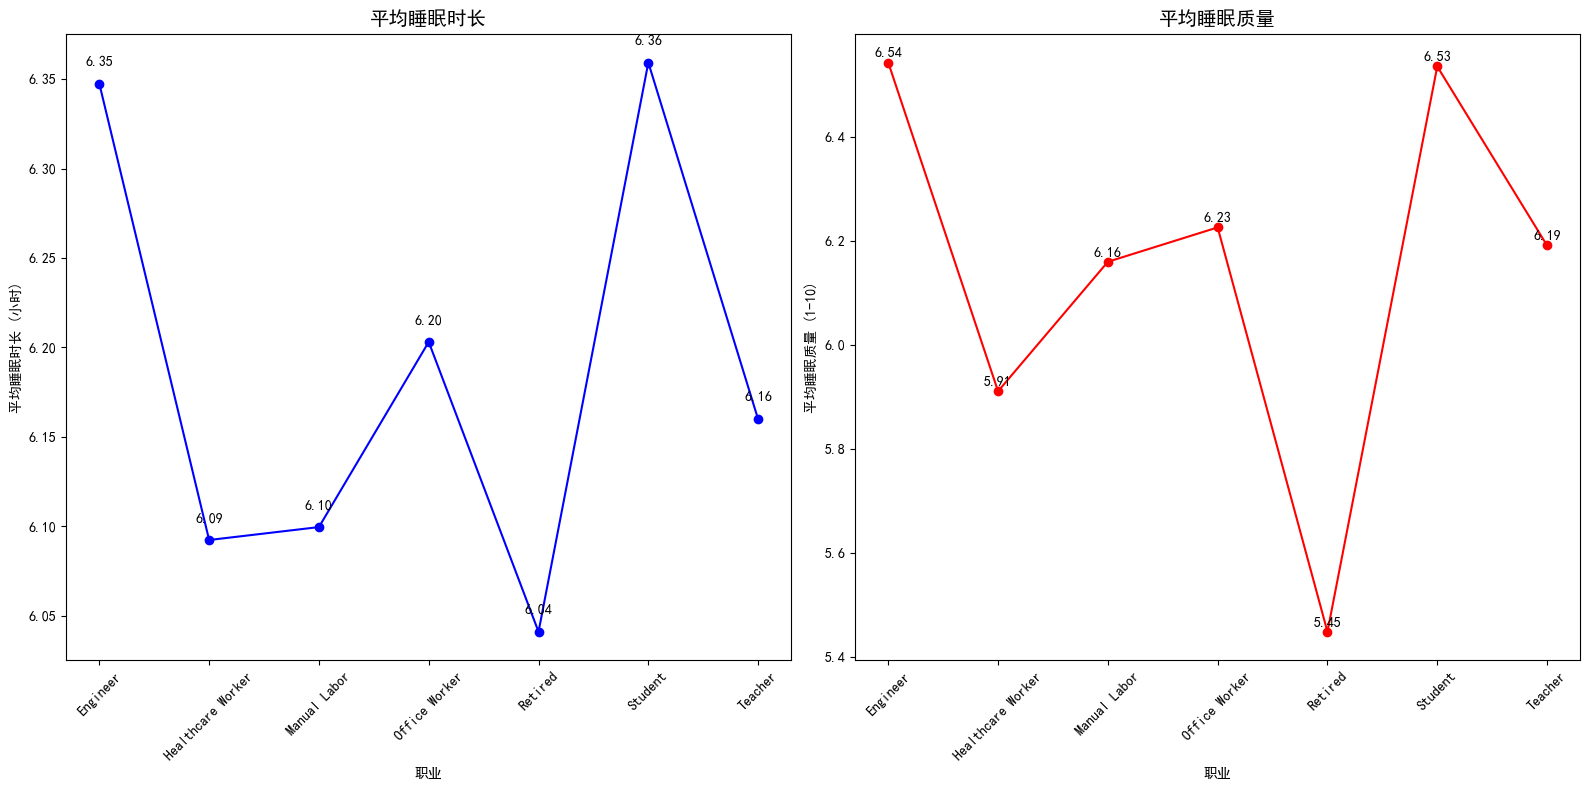

In [7]:
# 按职业分组，计算平均睡眠时长和睡眠质量评分
grouped_data = data.groupby('Occupation').agg({
    'Sleep Duration (hours)': 'mean',
    'Quality of Sleep (scale: 1-10)': 'mean'
}).reset_index()

# 对职业进行排序，确保折线图的顺序一致
grouped_data = grouped_data.sort_values(by='Occupation')

# 绘制折线图
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharex=True)

# 绘制平均睡眠时长的折线图
axes[0].plot(grouped_data['Occupation'], grouped_data['Sleep Duration (hours)'], marker='o', linestyle='-', color='b')
axes[0].set_title('平均睡眠时长', fontsize=14)
axes[0].set_xlabel('职业')
axes[0].set_ylabel('平均睡眠时长 (小时)')
axes[0].tick_params(axis='x', rotation=45)

# 在折线图的点上方标注数值
for i, value in enumerate(grouped_data['Sleep Duration (hours)']):
    axes[0].text(i, value + 0.01, f'{value:.2f}', ha='center')

# 绘制平均睡眠质量评分的折线图
axes[1].plot(grouped_data['Occupation'], grouped_data['Quality of Sleep (scale: 1-10)'], marker='o', linestyle='-', color='r')
axes[1].set_title('平均睡眠质量', fontsize=14)
axes[1].set_xlabel('职业')
axes[1].set_ylabel('平均睡眠质量 (1-10)')
axes[1].tick_params(axis='x', rotation=45)

# 在折线图的点上方标注数值
for i, value in enumerate(grouped_data['Quality of Sleep (scale: 1-10)']):
    axes[1].text(i, value + 0.01, f'{value:.2f}', ha='center')

plt.tight_layout()
plt.show()

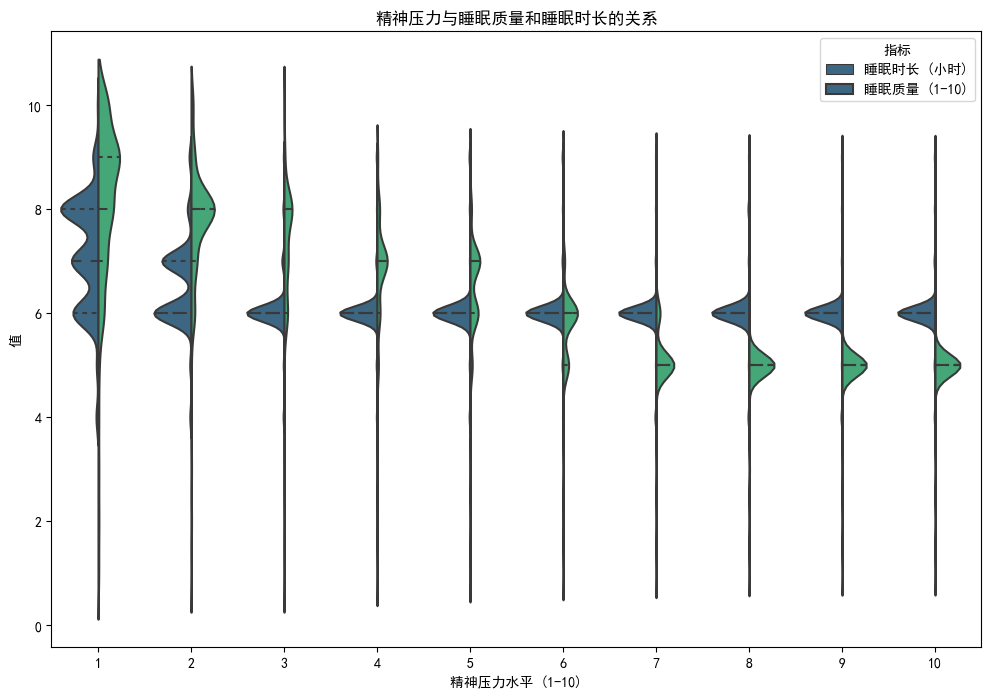

In [8]:
# 按精神压力分组，探寻精神压力与睡眠质量和睡眠时长的关系
melted_data = data.melt(id_vars=['Stress Level (scale: 1-10)'], 
                       value_vars=['Sleep Duration (hours)', 'Quality of Sleep (scale: 1-10)'],
                       var_name='Metric', value_name='Value')

# 绘制分组的小提琴图
plt.figure(figsize=(12, 8))
sns.violinplot(data=melted_data, x='Stress Level (scale: 1-10)', y='Value', hue='Metric', split=True, inner='quartile', palette='viridis')

# 添加标题和标签
plt.title('精神压力与睡眠质量和睡眠时长的关系')
plt.xlabel('精神压力水平 (1-10)')
plt.ylabel('值')
plt.legend(title='指标', labels=['睡眠时长 (小时)', '睡眠质量 (1-10)'])

# 显示图表
plt.show()

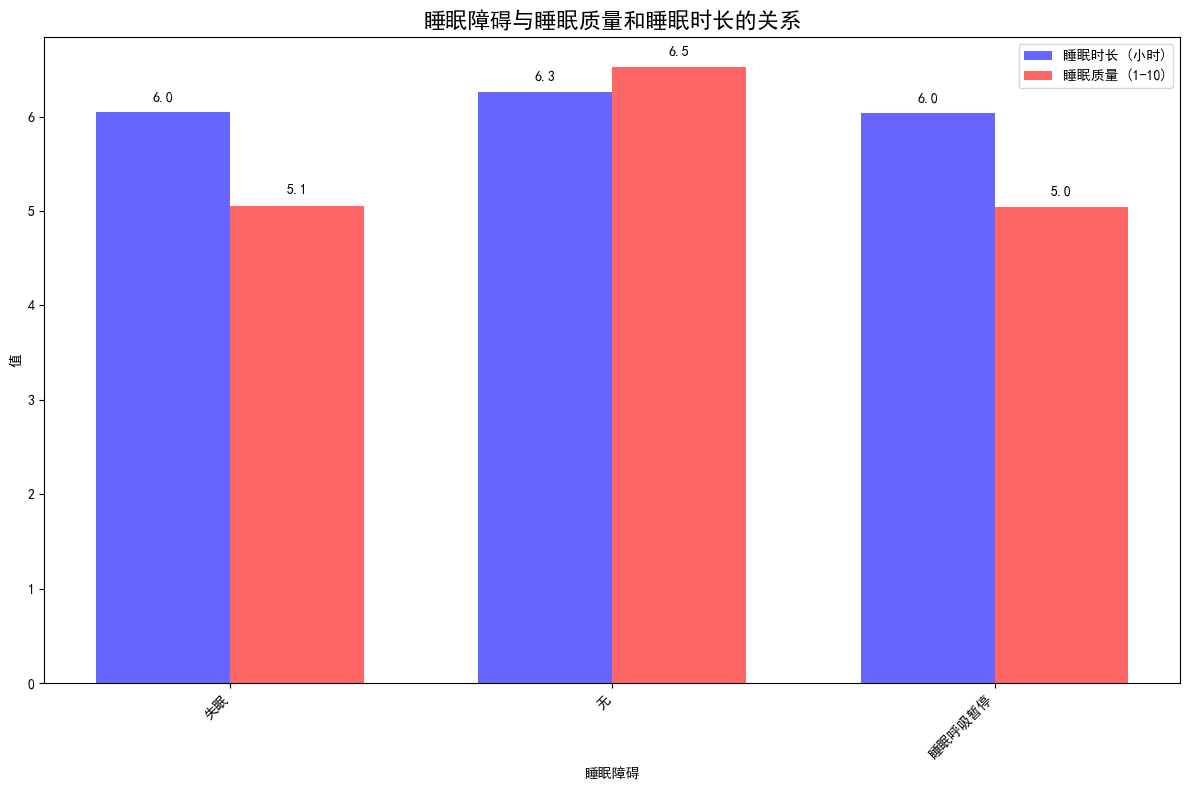

In [9]:
# 按睡眠障碍分组，计算平均睡眠时长和睡眠质量评分
grouped_data = data.groupby('Sleep Disorder').agg({
    'Sleep Duration (hours)': 'mean',
    'Quality of Sleep (scale: 1-10)': 'mean'
}).reset_index()

# 创建一个新的DataFrame，将睡眠质量和睡眠时长放在同一列中
melted_data = grouped_data.melt(id_vars=['Sleep Disorder'], 
                                value_vars=['Sleep Duration (hours)', 'Quality of Sleep (scale: 1-10)'],
                                var_name='Metric', value_name='Value')

# 绘制分组条形图
fig, ax = plt.subplots(figsize=(12, 8))

# 设置条形图的位置
bar_width = 0.35
index = range(len(grouped_data))

# 绘制睡眠时长的条形图
ax.bar(index, melted_data[melted_data['Metric'] == 'Sleep Duration (hours)']['Value'], bar_width, label='睡眠时长 (小时)', alpha=0.6, color='b')

# 绘制睡眠质量评分的条形图
ax.bar([i + bar_width for i in index], melted_data[melted_data['Metric'] == 'Quality of Sleep (scale: 1-10)']['Value'], bar_width, label='睡眠质量 (1-10)', alpha=0.6, color='r')

# 添加数值标签
for i in index:
    plt.text(i, grouped_data['Sleep Duration (hours)'][i] + 0.1, f'{grouped_data["Sleep Duration (hours)"][i]:.1f}', ha='center', va='bottom', color='black')
    plt.text(i + bar_width, grouped_data['Quality of Sleep (scale: 1-10)'][i] + 0.1, f'{grouped_data["Quality of Sleep (scale: 1-10)"][i]:.1f}', ha='center', va='bottom', color='black')

# 添加标题和标签
ax.set_xlabel('睡眠障碍')
ax.set_ylabel('值')
ax.set_title('睡眠障碍与睡眠质量和睡眠时长的关系', fontsize=16)
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(grouped_data['Sleep Disorder'], rotation=45, ha='right')
ax.set_xticklabels(['失眠', '无', '睡眠呼吸暂停'])
ax.legend()

# 显示图表
plt.tight_layout()
plt.show()

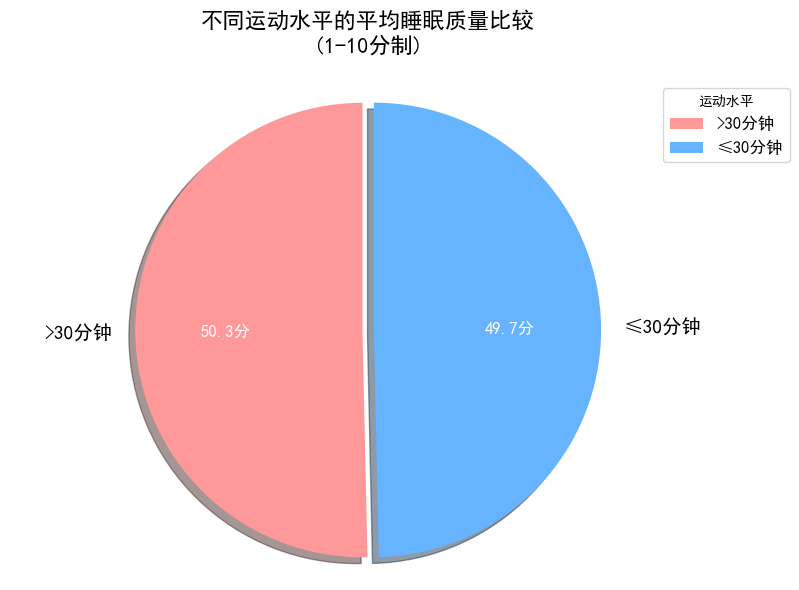

In [10]:
# 排除职业为 'Manual Labor' 的记录
data_filtered = data[data['Occupation'] != 'Manual Labor'].copy()

# 将每日运动时间分为两个区间：≤30分钟和>30分钟
data_filtered['Physical Activity Level'] = data_filtered['Physical Activity Level (minutes/day)'].apply(
    lambda x: '≤30分钟' if x <= 30 else '>30分钟'
)

# 计算每个运动区间的睡眠质量平均值
sleep_quality_by_activity = data_filtered.groupby('Physical Activity Level')['Quality of Sleep (scale: 1-10)'].mean().reset_index()

# 确保分组顺序一致
sleep_quality_by_activity = sleep_quality_by_activity.sort_values('Physical Activity Level', ascending=True)

# 创建饼图
plt.figure(figsize=(8, 6))

# 定义颜色
colors = ['#ff9999','#66b3ff']

# 绘制饼图
patches, texts, autotexts = plt.pie(
    sleep_quality_by_activity['Quality of Sleep (scale: 1-10)'],
    labels=sleep_quality_by_activity['Physical Activity Level'],
    autopct='%1.1f分',  # 显示具体分数
    startangle=90,
    colors=colors,
    explode=(0.05, 0),  # 突出显示第一块
    shadow=True,
    textprops={'fontsize': 14}
)

# 设置标题
plt.title('不同运动水平的平均睡眠质量比较\n(1-10分制)', 
          fontsize=16, pad=20, weight='bold')

# 调整百分比标签样式
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_weight('bold')
    autotext.set_fontsize(12)

# 添加图例
plt.legend(
    title='运动水平',
    loc='upper right',
    bbox_to_anchor=(1.1, 1),
    fontsize=12
)

# 添加中心圆使成环形图效果 (可选)
# centre_circle = plt.Circle((0,0),0.70,fc='white')
# fig = plt.gcf()
# fig.gca().add_artist(centre_circle)

# 确保图形是正圆
plt.axis('equal')

plt.tight_layout()
plt.show()

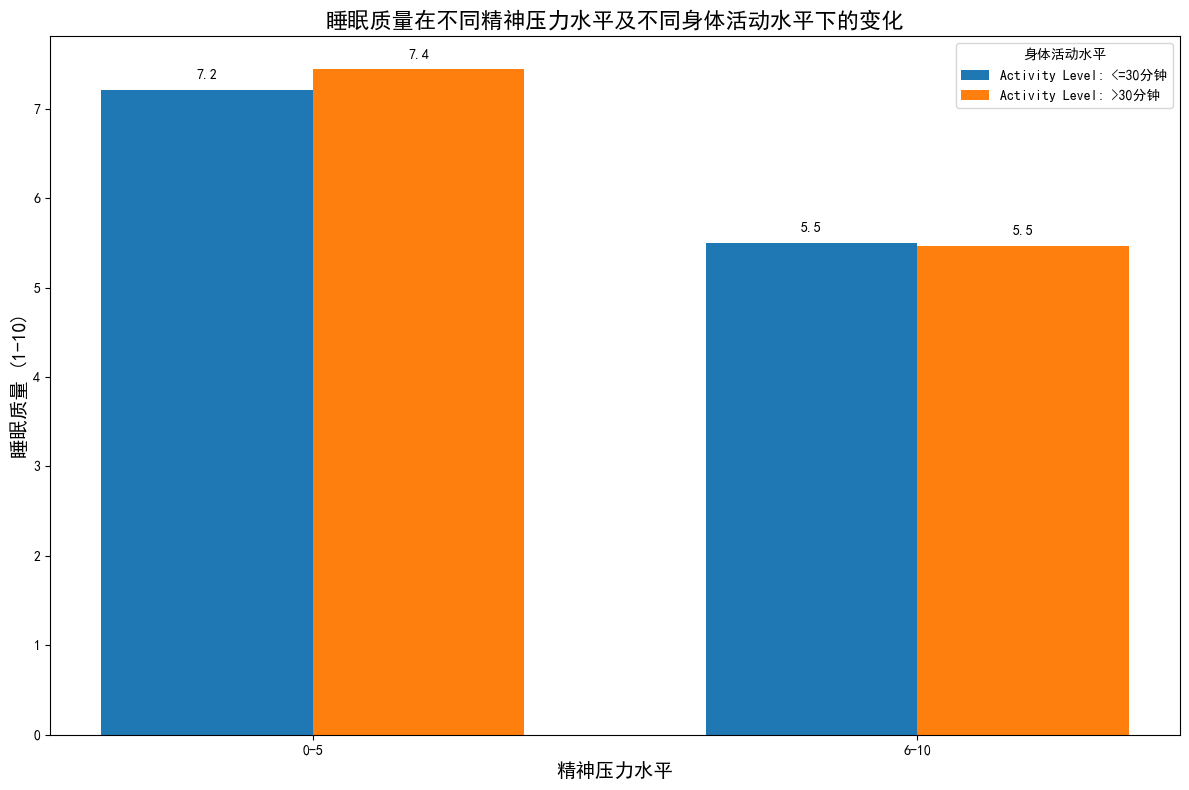

In [11]:
# 排除职业为 'Manual Labor' 的记录 - 添加.copy()创建独立副本
data_filtered = data[data['Occupation'] != 'Manual Labor'].copy()

# 使用.loc创建新列 - 表示运动时长是否超过30分钟
data_filtered.loc[:, 'Activity Level'] = data_filtered['Physical Activity Level (minutes/day)'].apply(
    lambda x: '>30' if x > 30 else '<=30'
)

# 使用.loc创建新列 - 将精神压力分组
stress_bins = [0, 5, 10]
stress_labels = ['0-5', '6-10']
data_filtered.loc[:, 'Stress Level Group'] = pd.cut(
    data_filtered['Stress Level (scale: 1-10)'],
    bins=stress_bins,
    labels=stress_labels,
    right=False
)

# 分组并计算每组的平均睡眠质量
grouped_data = data_filtered.groupby(['Stress Level Group', 'Activity Level'])['Quality of Sleep (scale: 1-10)'].mean().reset_index()

# 创建一个图形和轴
fig, ax = plt.subplots(figsize=(12, 8))

# 定义颜色
colors = ['#1f77b4', '#ff7f0e']

# 绘制柱状图
bar_width = 0.35
index = range(len(stress_labels))

for i, activity_level in enumerate(['<=30', '>30']):
    subset = grouped_data[grouped_data['Activity Level'] == activity_level]
    bars = ax.bar(
        [x + i * bar_width for x in index],
        subset['Quality of Sleep (scale: 1-10)'],
        bar_width,
        label=f'Activity Level: {activity_level}分钟',
        color=colors[i]
    )
    
    # 标注数据
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height + 0.1,
            f'{height:.1f}',
            ha='center',
            va='bottom',
            color='black'
        )

# 添加标题和标签
ax.set_title('睡眠质量在不同精神压力水平及不同身体活动水平下的变化', fontsize=16)
ax.set_xlabel('精神压力水平', fontsize=14)
ax.set_ylabel('睡眠质量 (1-10)', fontsize=14)
ax.set_xticks([x + bar_width / 2 for x in index])
ax.set_xticklabels(stress_labels)
ax.legend(title='身体活动水平')

# 显示图形
plt.tight_layout()
plt.show()

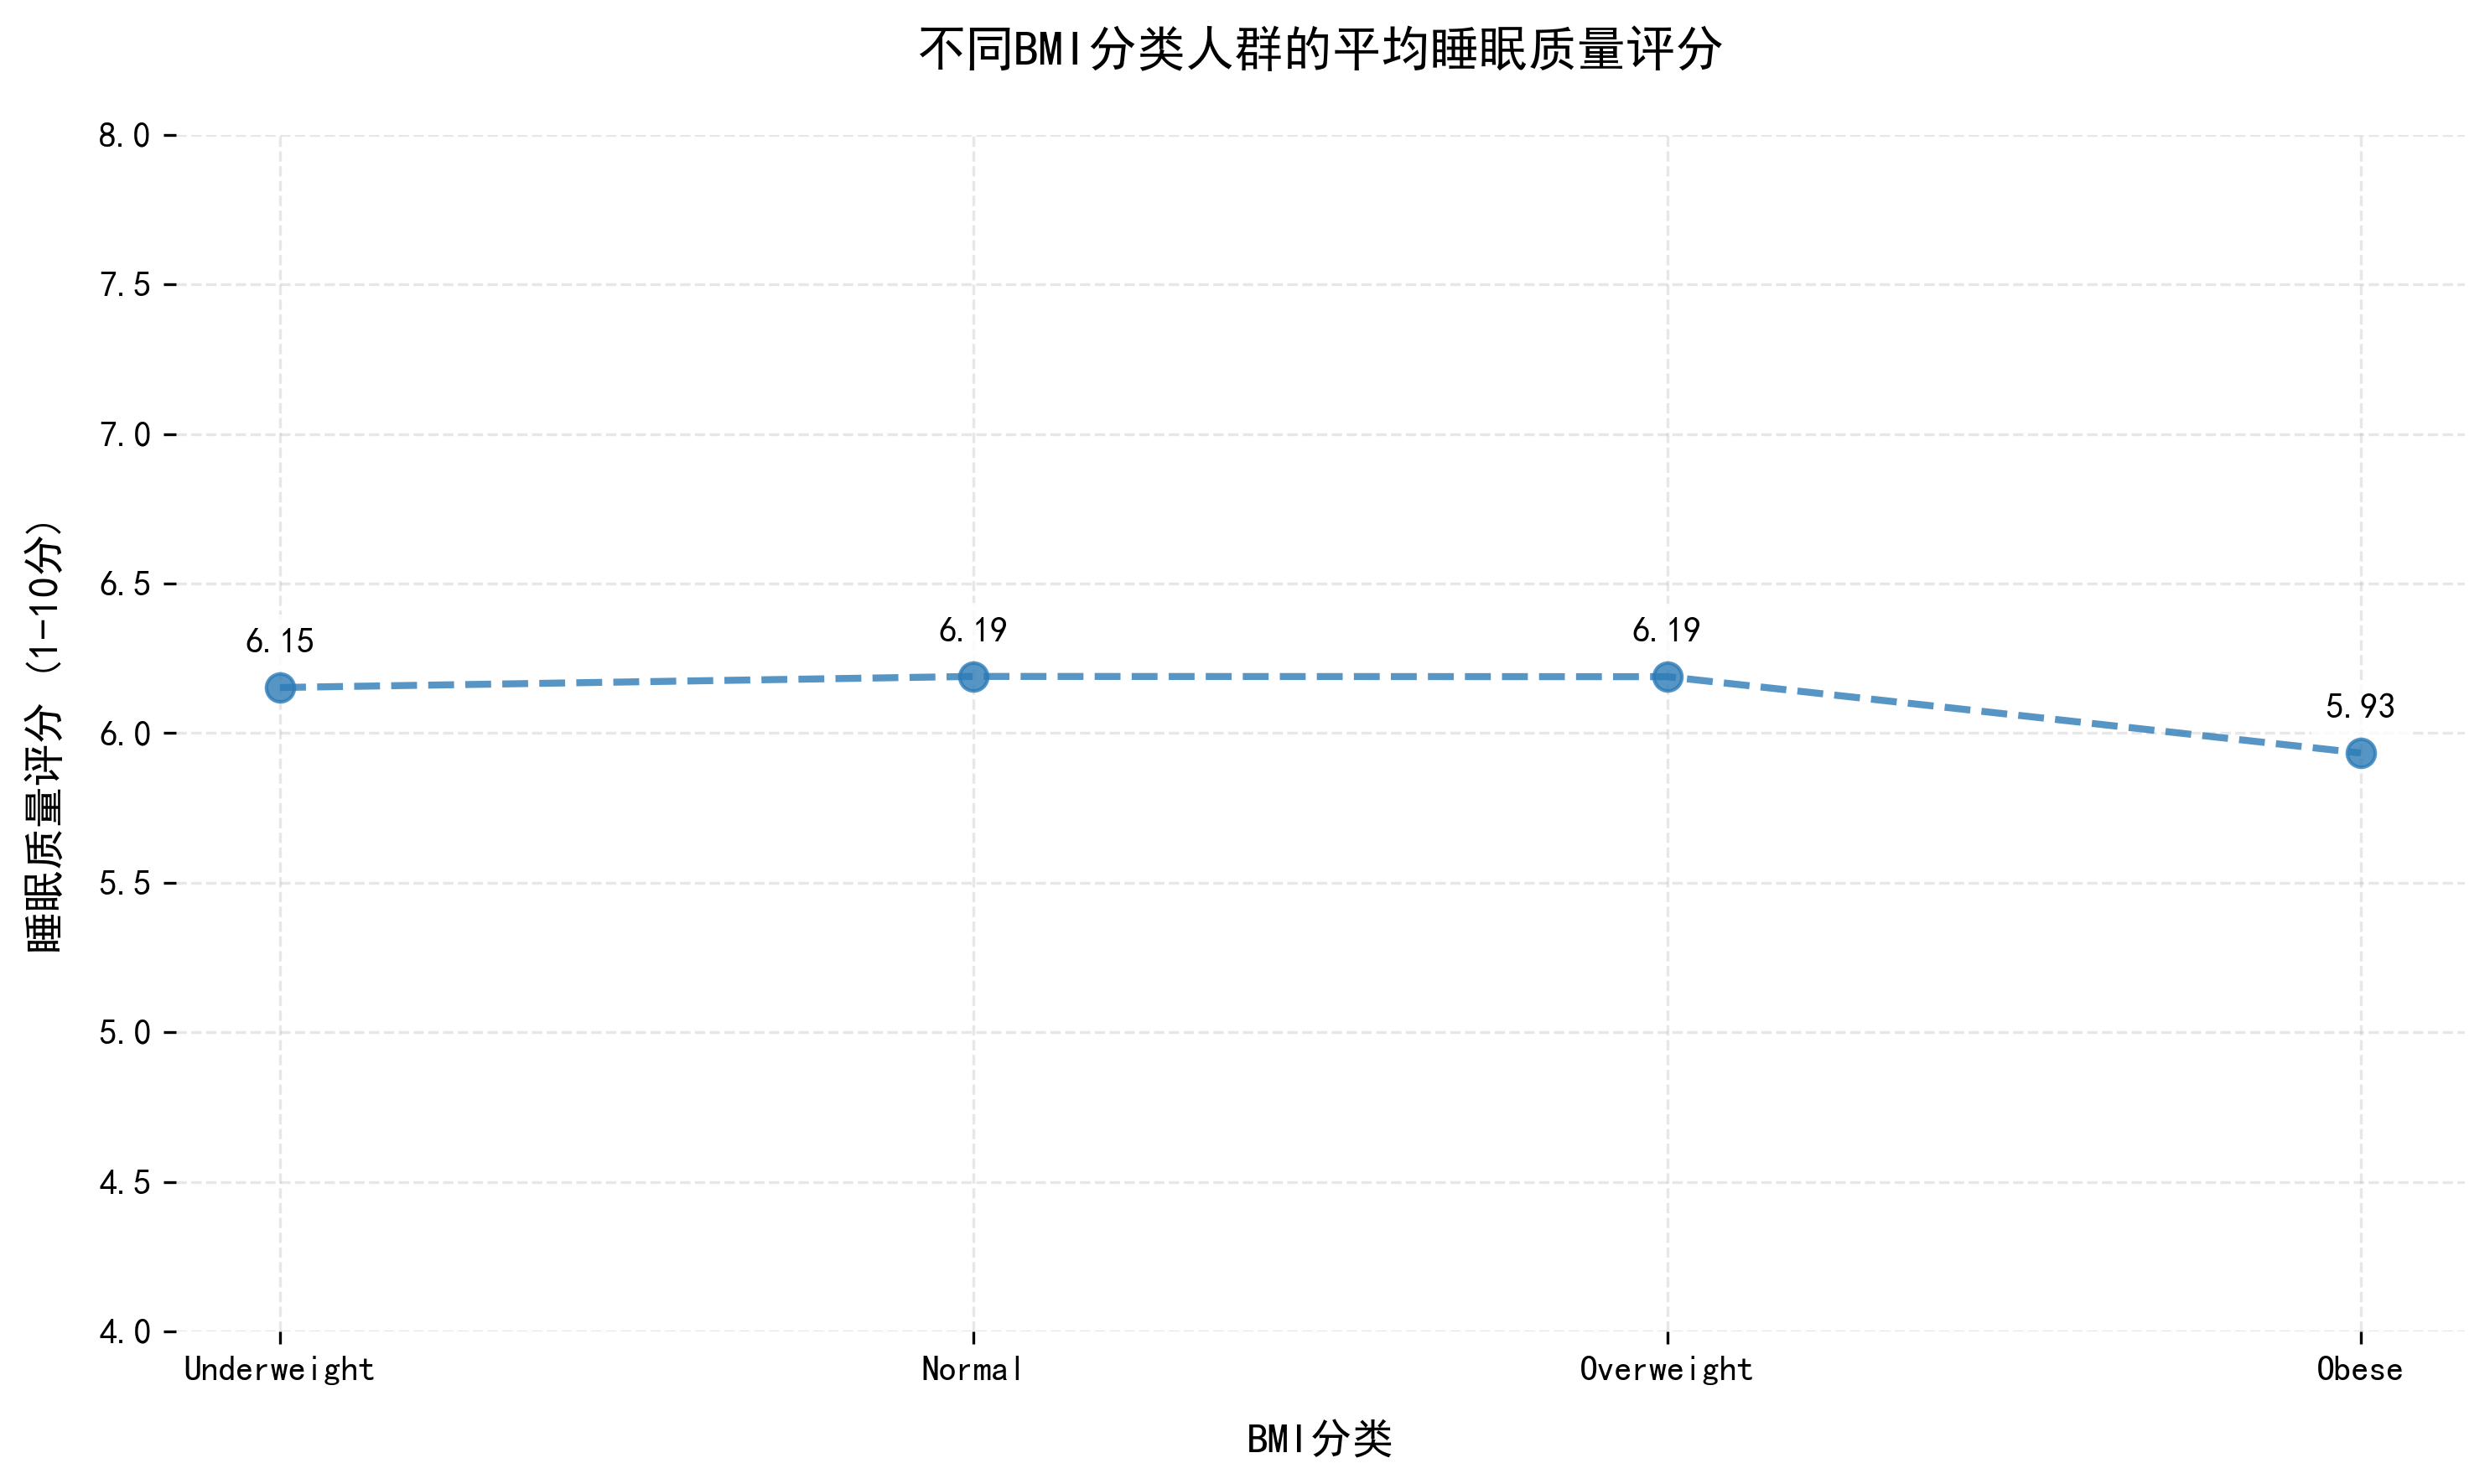

In [20]:
# 按BMI类别分组，计算平均睡眠质量
grouped_data = data.groupby('BMI Category').agg({
    'Quality of Sleep (scale: 1-10)': ['mean', 'sem']
}).reset_index()
grouped_data.columns = ['BMI Category', 'Mean Quality', 'SEM']

# 对BMI进行科学排序
bmi_order = ['Underweight', 'Normal', 'Overweight', 'Obese']
grouped_data['BMI Category'] = pd.Categorical(grouped_data['BMI Category'], categories=bmi_order, ordered=True)
grouped_data = grouped_data.sort_values('BMI Category')

# 创建专业可视化
plt.figure(figsize=(10, 6), dpi=300)

# 绘制带误差线的折线图
line = plt.plot(grouped_data['BMI Category'], 
                grouped_data['Mean Quality'], 
                marker='o', 
                markersize=8,
                linestyle='--',
                linewidth=2,
                color='#2c7bb6',
                alpha=0.8)



# 添加数据标签
for x, y in zip(grouped_data['BMI Category'], grouped_data['Mean Quality']):
    plt.text(x, y+0.1, f'{y:.2f}', 
             ha='center',
             va='bottom',
             fontsize=10,
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

# 设置图表样式
plt.title('不同BMI分类人群的平均睡眠质量',
          fontsize=14,
          pad=20)
plt.xlabel('BMI分类', fontsize=12, labelpad=10)
plt.ylabel('睡眠质量评分 (1-10分)', fontsize=12, labelpad=10)
plt.ylim(4, 8)  # 优化Y轴范围以突出差异

# 添加网格线
plt.grid(True, linestyle='--', alpha=0.3)

#

# 优化边框
for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.tight_layout()
plt.show()